In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sn
import json

Load data, I have a file on the migration stock, and one with populations in 2015 which includes the country code and has the country names as they are in the migration stock file.

I need to set up an edgelist with origin, destination and weight, countries should be named from the country code and the weight need to later be adjusted to the origin population.

In [2]:
df_main = pd.read_excel("../Data/UN/edit/migration_stock.xlsx")

In [3]:
df_main.head(2)

,Year,Destination,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Anguilla,Antigua and Barbuda,...,Uruguay,Uzbekistan,Vanuatu,Venezuela (Bolivarian Republic of),Viet Nam,Wallis and Futuna Islands,Western Sahara,Yemen,Zambia,Zimbabwe
0,2015,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,229.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df_pop = pd.read_excel("../Data/UN/edit/data_merged.xlsx", sheet_name="data")

In [5]:
df_pop.head(2)

,country_migration,country,code,population_2015
0,Afghanistan,Afghanistan,AFG,33753499.0
1,Albania,Albania,ALB,2882481.0


In [6]:
code2pop = dict(df_pop[["code", "population_2015"]].values)

If the input is the same for the two matrices that are the result of splitting migstock, then a simple matrix operation of one minus the other will give the adjency matrix and from this it should be a lot easier to work with.

In [7]:
df_19 = df_main[df_main["Year"] == 2019].copy()
df_15 = df_main[df_main["Year"] == 2015].copy()

In [8]:
df_15 = df_15.drop("Year", axis=1).set_index("Destination", drop=True).fillna(0)
df_19 = df_19.drop("Year", axis=1).set_index("Destination", drop=True).fillna(0)

In [9]:
df_adj = df_19 - df_15

In [10]:
edgelist = []

for origin in df_adj.columns:
    df_origin = df_adj[origin][df_adj[origin] > 0]
    edges = [(origin, dest, weight) for dest, weight in zip(df_origin.index,df_origin.values)]
    edgelist.extend(edges)

In [11]:
df_edgelist = pd.DataFrame(edgelist, columns=["origin", "destination", "weight"])

Now I will translate the country names to the 3 digit code and scale the weight to the population size

In [12]:
country2code = dict(df_pop[["country_migration", "code"]].values)

In [13]:
df_edgelist["origin"] = df_edgelist["origin"].apply(lambda x: country2code[x])
df_edgelist["destination"] = df_edgelist["destination"].apply(lambda x: country2code[x])

In [14]:
# A few countries has no equivalent in the population data, these are removed
df_edgelist = df_edgelist.dropna().copy()

In [15]:
df_edgelist["population_origin"] = [code2pop[code] for code in df_edgelist["origin"]]

In [16]:
# number of migrants in destination country per 10000 migrants from origin
df_edgelist["weight_scaled"] = df_edgelist["weight"] / df_edgelist["population_origin"] * 10000

In [17]:
df_edgelist.to_excel("../Data/edgelist/UN_full.xlsx")

In [17]:
DiEdgelist = [(origin, destination, {"weight":weight}) for [origin, destination, weight] in df_edgelist[["origin","destination","weight_scaled"]].values]

In [18]:
G = nx.DiGraph(DiEdgelist)

In [19]:
print("Number of nodes: ", len(G.nodes()), "\n", "Number of edges: ", len(G.edges()))

Number of nodes:  226 
 Number of edges:  8297


In [20]:
weights = [edge[2]["weight"] for edge in G.edges(data=True)]

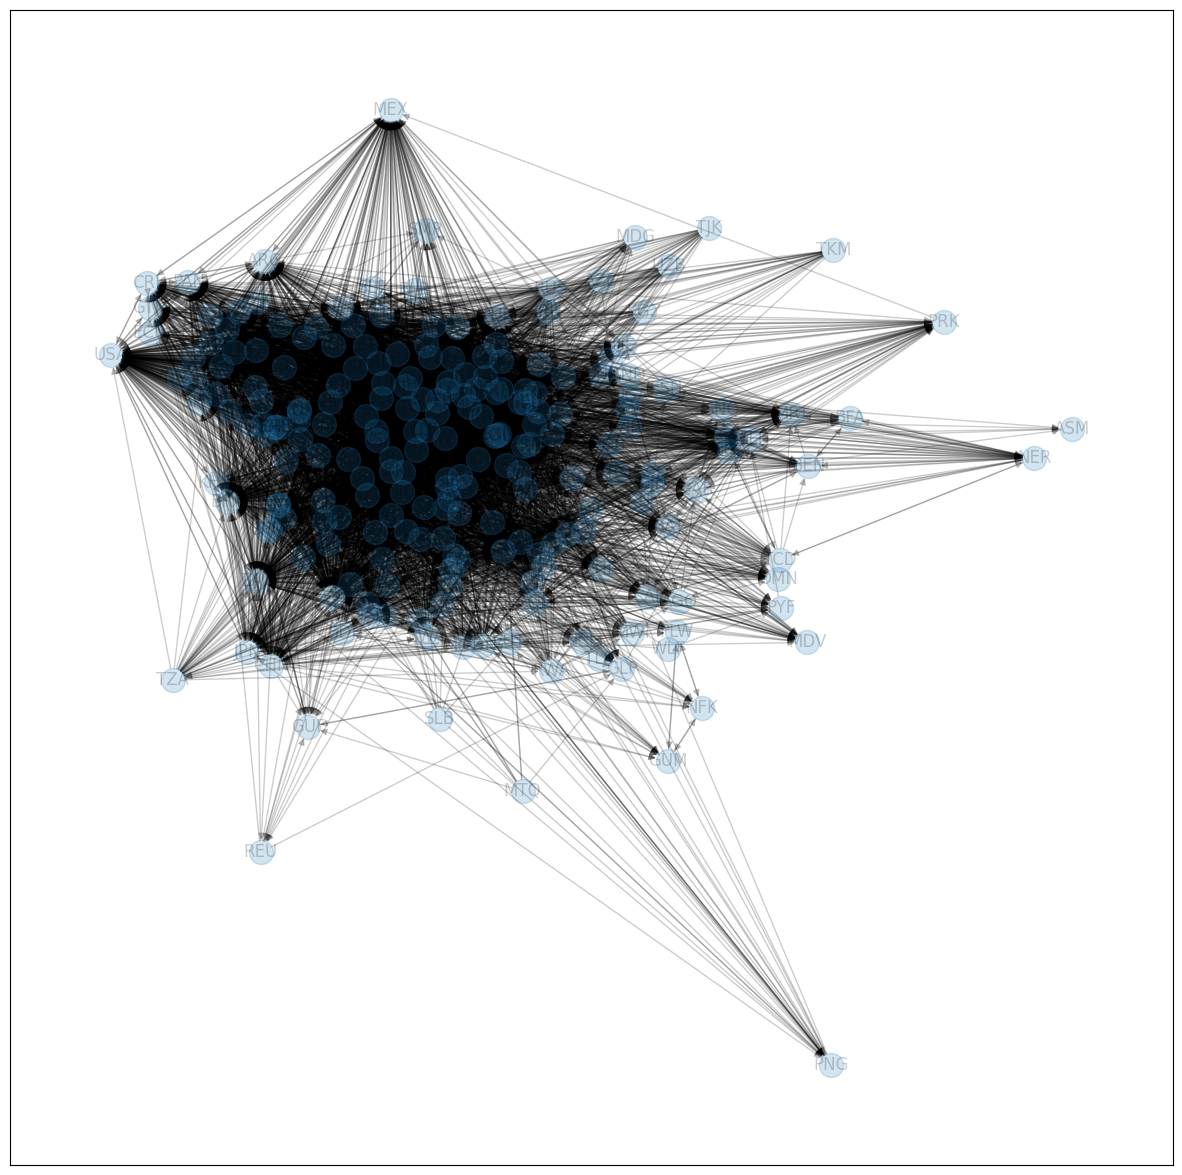

In [84]:
fig, ax = plt.subplots(figsize=(15,15))

nx.draw_networkx(G, alpha=0.2)

In [21]:
G["AFG"]

AtlasView({'AUS': {'weight': 3.036129676511463}, 'AUT': {'weight': 3.537707305544827}, 'BHR': {'weight': 0.010073029762040374}, 'BEL': {'weight': 3.130638396925901}, 'BRA': {'weight': 0.0023701246498918525}, 'BGR': {'weight': 0.019553528361607786}, 'CAN': {'weight': 1.0955901194125088}, 'LKA': {'weight': 0.00029626558123648156}, 'CHL': {'weight': 0.004443983718547224}, 'COL': {'weight': 0.0005925311624729631}, 'CZE': {'weight': 0.029034026961175196}, 'DNK': {'weight': 0.4171419383809661}, 'ECU': {'weight': 0.013331951155641671}, 'EST': {'weight': 0.004740249299783705}, 'FIN': {'weight': 0.796658147944899}, 'FRA': {'weight': 0.112580920869863}, 'GEO': {'weight': 0.00029626558123648156}, 'DEU': {'weight': 36.95616860343871}, 'GRC': {'weight': 1.7370051027894917}, 'HUN': {'weight': 0.03021908928612112}, 'ISL': {'weight': 0.006221577205966114}, 'IND': {'weight': 0.17094524037344988}, 'IRQ': {'weight': 0.002073859068655371}, 'IRL': {'weight': 0.004147718137310742}, 'ITA': {'weight': 1.30090

In [22]:
# Let's start by getting the adjacency matrix
A = nx.adjacency_matrix(G).toarray()

In [24]:
for i in range(len(A)):
    A[i,:] /= A[i,:].sum()

In [46]:
# For convenience, let's make it into a pandas dataframe
df = pd.DataFrame(A).stack().reset_index()
df.columns = ("source", "target", "weight")
df = df[df["weight"] > 0]

In [68]:
indexNodes = {i: node for i, node in enumerate(G.nodes())}

In [69]:
quat25 = df["weight"].describe()["25%"]

In [72]:
removeEdges = [(indexNodes[int(origin)], indexNodes[int(destination)]) for [origin, destination, weight] in df[df["weight"]<quat25].values]

In [74]:
for (origin, destination) in removeEdges:
    G.remove_edge(origin, destination)

In [94]:
weights = np.array([edge[2]["weight"] for edge in G.edges(data=True)])

In [95]:
def scale_x(x):
    min_weight = np.min(weights)
    max_weight = np.max(weights)
    min_scale = 0.1
    max_scale = 2.5
    return (((max_scale-min_scale)*(x-min_weight))/(max_weight-min_weight))+min_scale

In [96]:
weights_scaled = [scale_x(w) for w in weights]

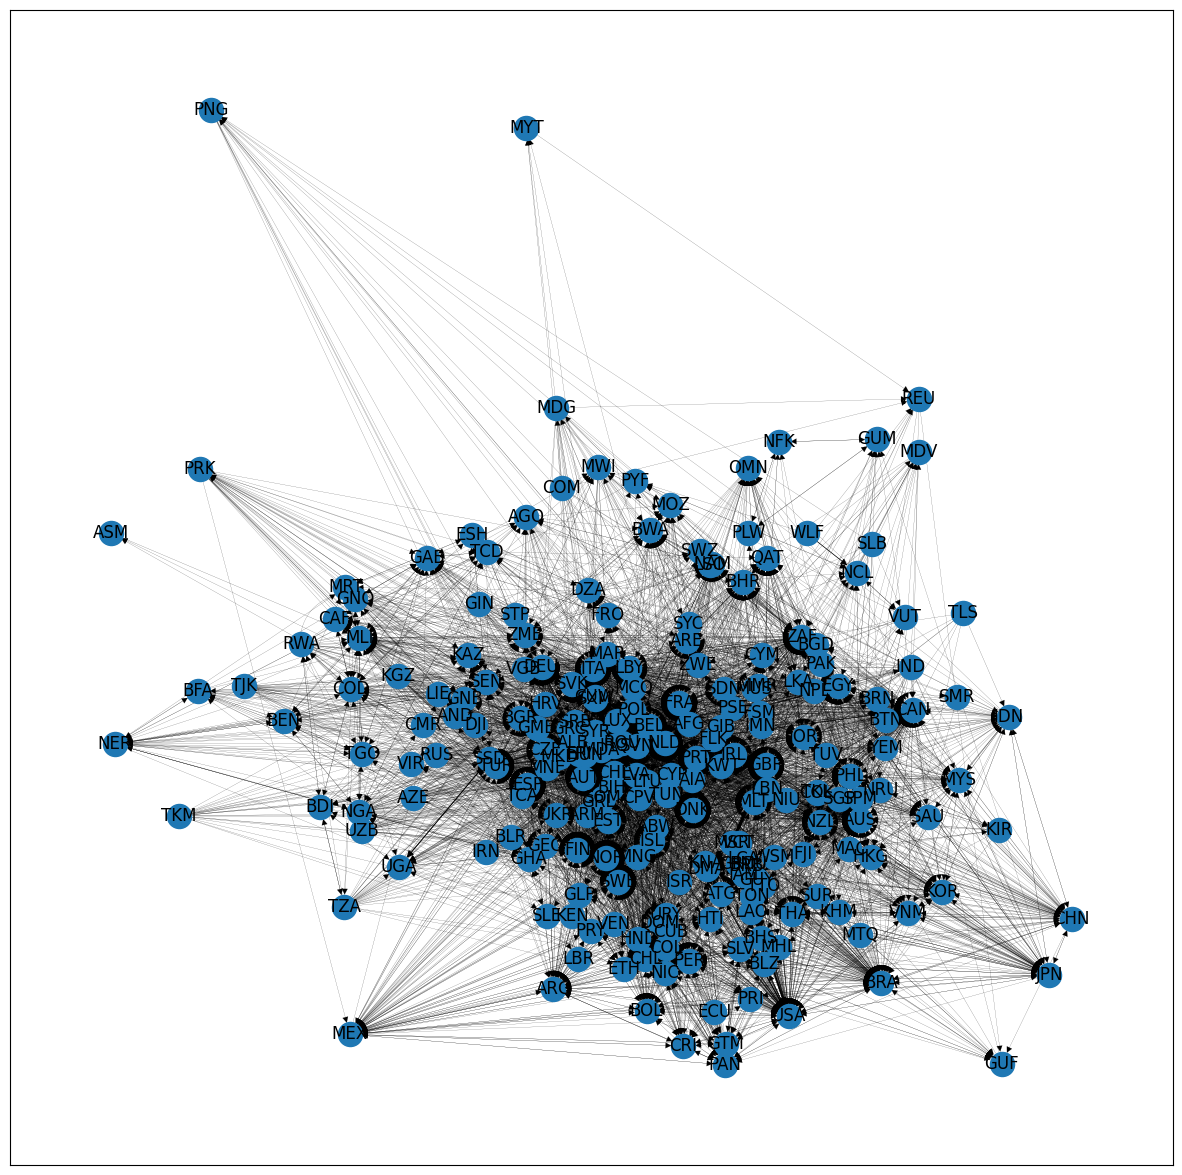

In [97]:
fig, ax = plt.subplots(figsize=(15,15))

nx.draw_networkx(G, width=weights_scaled)